---
title: 'Fluent dreaming for language models'
date: 01/23/2024
author:
  - name: 
      given: T. Ben
      family: Thompson
    email: t.ben.thompson@gmail.com
  - name: Zygimantas Straznickas
  - name: Michael Sklar
bibliography: biblio.bib
format:
  html: default
  ipynb: default
description: Paper companion page.

---

This is a companion page for our paper, ["Fluent dreaming for language models." (arXiv link)](http:///arxiv).


::: {.callout-note title="Dreaming Phi-2" appearance="minimal"} 

In [19]:
#| echo: false
from IPython.display import HTML, display
with open('viz.html', 'r') as f:
    html = f.read()
display(HTML(html))

:::


Dreaming is the process of maximizing some internal or output feature of a neural network by iteratively tweaking the input to the network. The most well-known example is DeepDream [@mordvintsev-2015]. Besides making pretty images, dreaming is useful for interpreting the purpose of the internal components of a neural network [@cammarata2020thread; @olah2017feature; @yosinski2015understanding]. Dreaming has only been applied to vision models because the input space to a vision model is approximately continuous and algorithms like gradient descent work well. For language models, the input space is discrete and very different algorithms are needed. Extending work in the adversarial attacks literature [@zou2023universal], in the paper, we introduce the Evolutionary Prompt Optimization (EPO) algorithm for dreaming with language models. 

On this page, we demonstrate running the EPO algorithm for a neuron in Phi-2. There is also a Colab notebook version of this page available.

![](dream_wow.png)

## Installation and setup 

::: {.callout-note title="Click to view install and imports" collapse="true" appearance="minimal"}

First, we install necessary dependencies and install the `dreamy` library:

In [1]:
#| output: false
!pip install "poetry==1.7.1" "torch==2.1.2" "numpy==1.26.3" "transformers==4.37.0" "accelerate==0.26.1" pandas pyarrow matplotlib ipywidgets
![ -e dreamy_clone ] && rm -rf dreamy_clone
!git clone https://github.com/Confirm-Solutions/dreamy dreamy_clone
!cd dreamy_clone; poetry install

Cloning into 'dreamy_clone'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 8), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (27/27), 16.45 KiB | 1.50 MiB/s, done.
Installing dependencies from lock file

Installing the current project: dreamy (0.0.1)Installing the current project: dreamy (0.0.1)


Next, we import the `dreamy` library and load Phi-2:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from IPython.display import HTML, display

from dreamy.epo import epo, add_fwd_hooks, build_pareto_frontier
from dreamy.attribution import resample_viz

%config InlineBackend.figure_format='retina'
np.set_printoptions(edgeitems=10, linewidth=100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 500)

:::
    
We load up the Phi-2 model:

In [3]:
#| output: false
model_name = "microsoft/phi-2"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype="auto",
    use_cache=False,
    device_map="cuda"
)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Running EPO

In this section, we run the EPO algorithm. In order to use EPO, we first need to define an objective function. The objective function is responsible for executing a model forward pass and capturing whatever optimization "target" that we want to maximize. The API for defining an objective function is:

- accept an arbitrary set of arguments that will be passed on to the model.
- return a dictionary with a minimum of two keys:
    - `target`: a target scalar that will be maximized.
    - `logits`: the token probabilities output by the model. These are used to calculate cross-entropy/fluency.
    - other keys in the dictionary can optionally be used to pass info to a per-iteration monitoring `callback`. For more details, see the docstring of the `epo` function.
      
Here, we are going to define an objective that maximizes the activation of a chosen neuron in Phi-2. We use a hook on the MLP layer to capture the activations of the chosen neuron. We maximize the activation only on the last token of the sequence.

In [4]:
def neuron_runner(layer, neuron):
    def f(*model_args, **model_kwargs):
        out = {}

        def get_target(module, input, output):
            out["target"] = input[0][:, -1, neuron]

        with add_fwd_hooks(
            [
                (model.model.layers[layer].mlp.fc2, get_target),
            ]
        ):
            out["logits"] = model(*model_args, **model_kwargs).logits
        return out

    return f

In [5]:
#| output: false
runner = neuron_runner(layer=8, neuron=1)
history = epo(runner, model, tokenizer)

runtime: 0.77 seconds

beginning step 0, current pareto frontier prompts:
penalty=0.01 xentropy=14.45 target=-0.01 ' deductions1989Gre Shattered Presents ignorant usbCrash incoming Aluminum chargbones[\n]'
penalty=0.03 xentropy=13.12 target=-0.05 ' sexes spit magazine modfiletic McFEmemployment APR doors trop[ics]'
restarting with xentropy penalty of 4.66
runtime: 0.37 seconds

beginning step 1, current pareto frontier prompts:
penalty=0.01 xentropy=12.28 target=-0.03 ' sexes spit magazine modfilin McFEmemployment APR doors trop[ics]'
runtime: 0.35 seconds

beginning step 2, current pareto frontier prompts:
penalty=0.01 xentropy=11.54 target=-0.02 ' sexes test magazine modfilin McFEmemployment APR doors trop[ics]'
penalty=0.11 xentropy=11.44 target=-0.03 ' sexes spit magazine modfilin McFEmemployment education doors trop[ics]'
penalty=2.58 xentropy=11.43 target=-0.05 ' sexes spit magazine modfilin McFEmemployment stop doors trop[ics]'
runtime: 0.35 seconds

beginning step 3, current pa

```
beginning step 299, current pareto frontier prompts:
penalty=0.01 xentropy=8.09 target=4.56 ' study found another pattern by told-Mike Heyya, making[ the]'
penalty=0.16 xentropy=7.59 target=4.48 ' study found another pattern by told-Mike Heyde, making[ the]'
penalty=0.41 xentropy=5.16 target=3.50 ' study encountered another example of similar-unmatched pairs, with[ the]'
penalty=0.98 xentropy=4.43 target=2.80 ' study found another pattern of similar-unmatched pairs, with[ the]'
penalty=2.25 xentropy=4.43 target=2.80 ' study found another pattern of similar-unmatched pairs, with[ the]'
```

## The Pareto frontier

To visualize the results of this EPO run, we first plot the Pareto frontier of cross-entropy against activation.

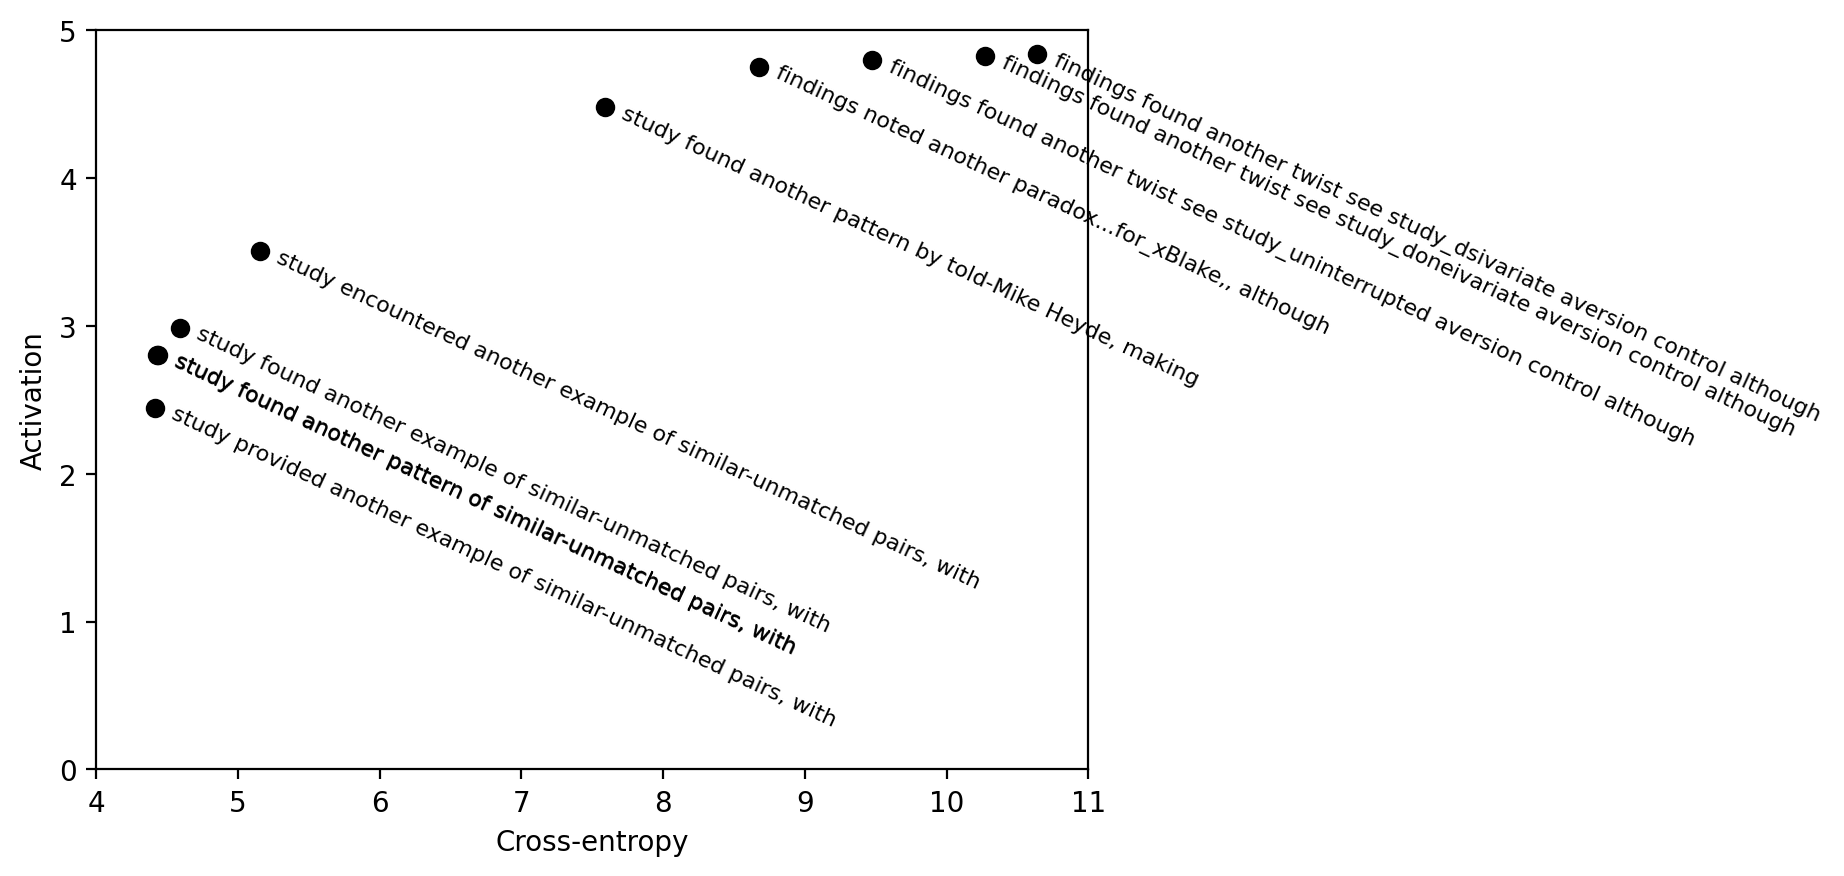

In [6]:
pareto = build_pareto_frontier(tokenizer, history)

ordering = np.argsort(pareto.xentropy)
plt.scatter(pareto.xentropy, pareto.target, c='k', label='Pareto frontier')
for i, k in enumerate(ordering):
    plt.text(pareto.xentropy[k] + 0.05, pareto.target[k] + 0.05, pareto.text[k], fontsize=8, rotation=-25, va='top', color='black', alpha=1.0)
plt.xlim(4, 11)
plt.ylim(0, 5)
plt.xlabel('Cross-entropy')
plt.ylabel('Activation')
plt.show()

We also plot the evolution of the Pareto frontier over the course of the optimization run.

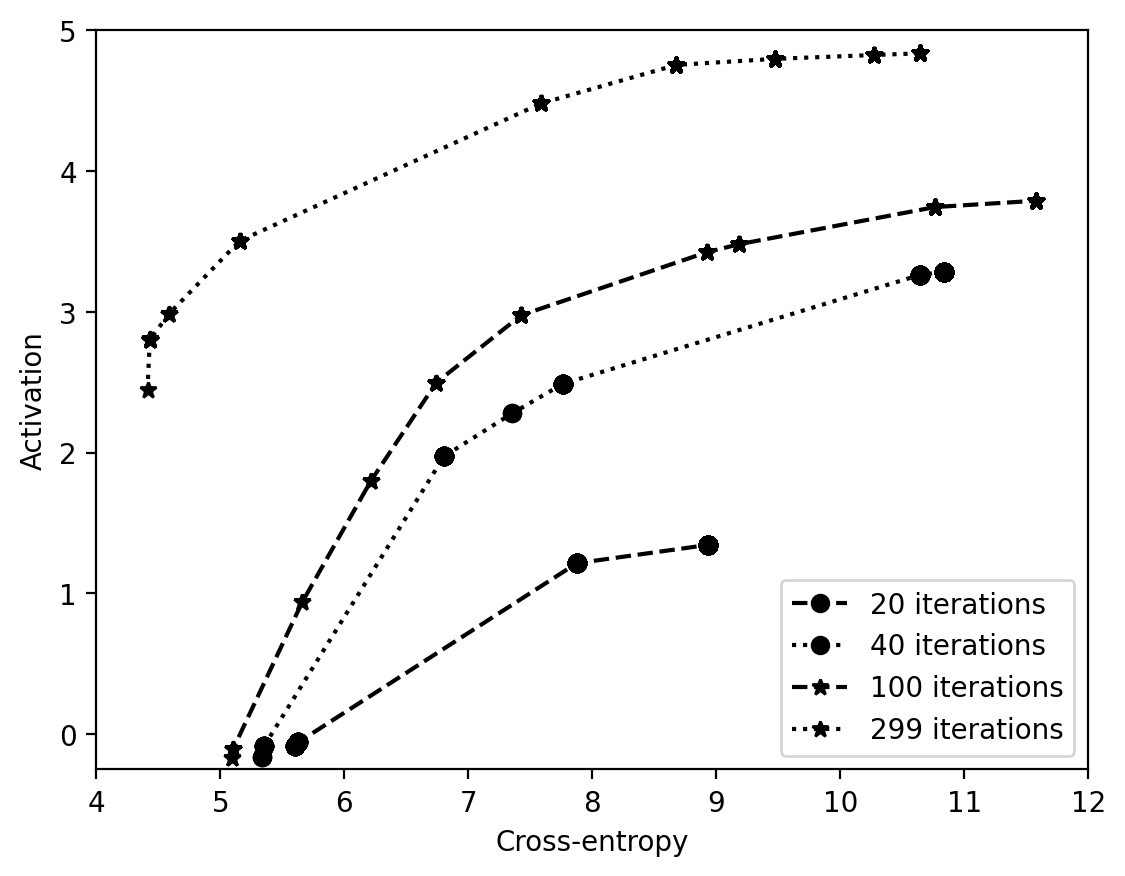

In [7]:
linestyles = ['k--o', 'k:o', 'k--*', 'k:*']
for i, n in enumerate([20, 40, 100, 299]):
    pareto = build_pareto_frontier(tokenizer, history.subset(slice(0, n)))
    ordering = np.argsort(pareto.xentropy)
    plt.plot(pareto.full_xentropy, pareto.full_target, linestyles[i % len(linestyles)], label=f"{n} iterations")
plt.xlabel('Cross-entropy')
plt.ylabel('Activation')
plt.xlim([4, 12])
plt.ylim([-0.25, 5])
plt.legend(loc='lower right')
plt.show()

## Thresholding cross-entropy

An alternative way of visualizing the results of an EPO run is to consider only the subset of prompts with cross-entropy below some fixed threshold. Below, we plot the maximum activation across the 300 iterations of EPO for six different thresholds. The title of each plot shows the maximum activating prompt under the cross-entropy threshold across all iterations. The sharp drops every 50 iterations are from restarts. Sometimes there's a plateau before the restart and other times progress is continuing. This suggests that a more adaptive restarting algorithm would perform better.

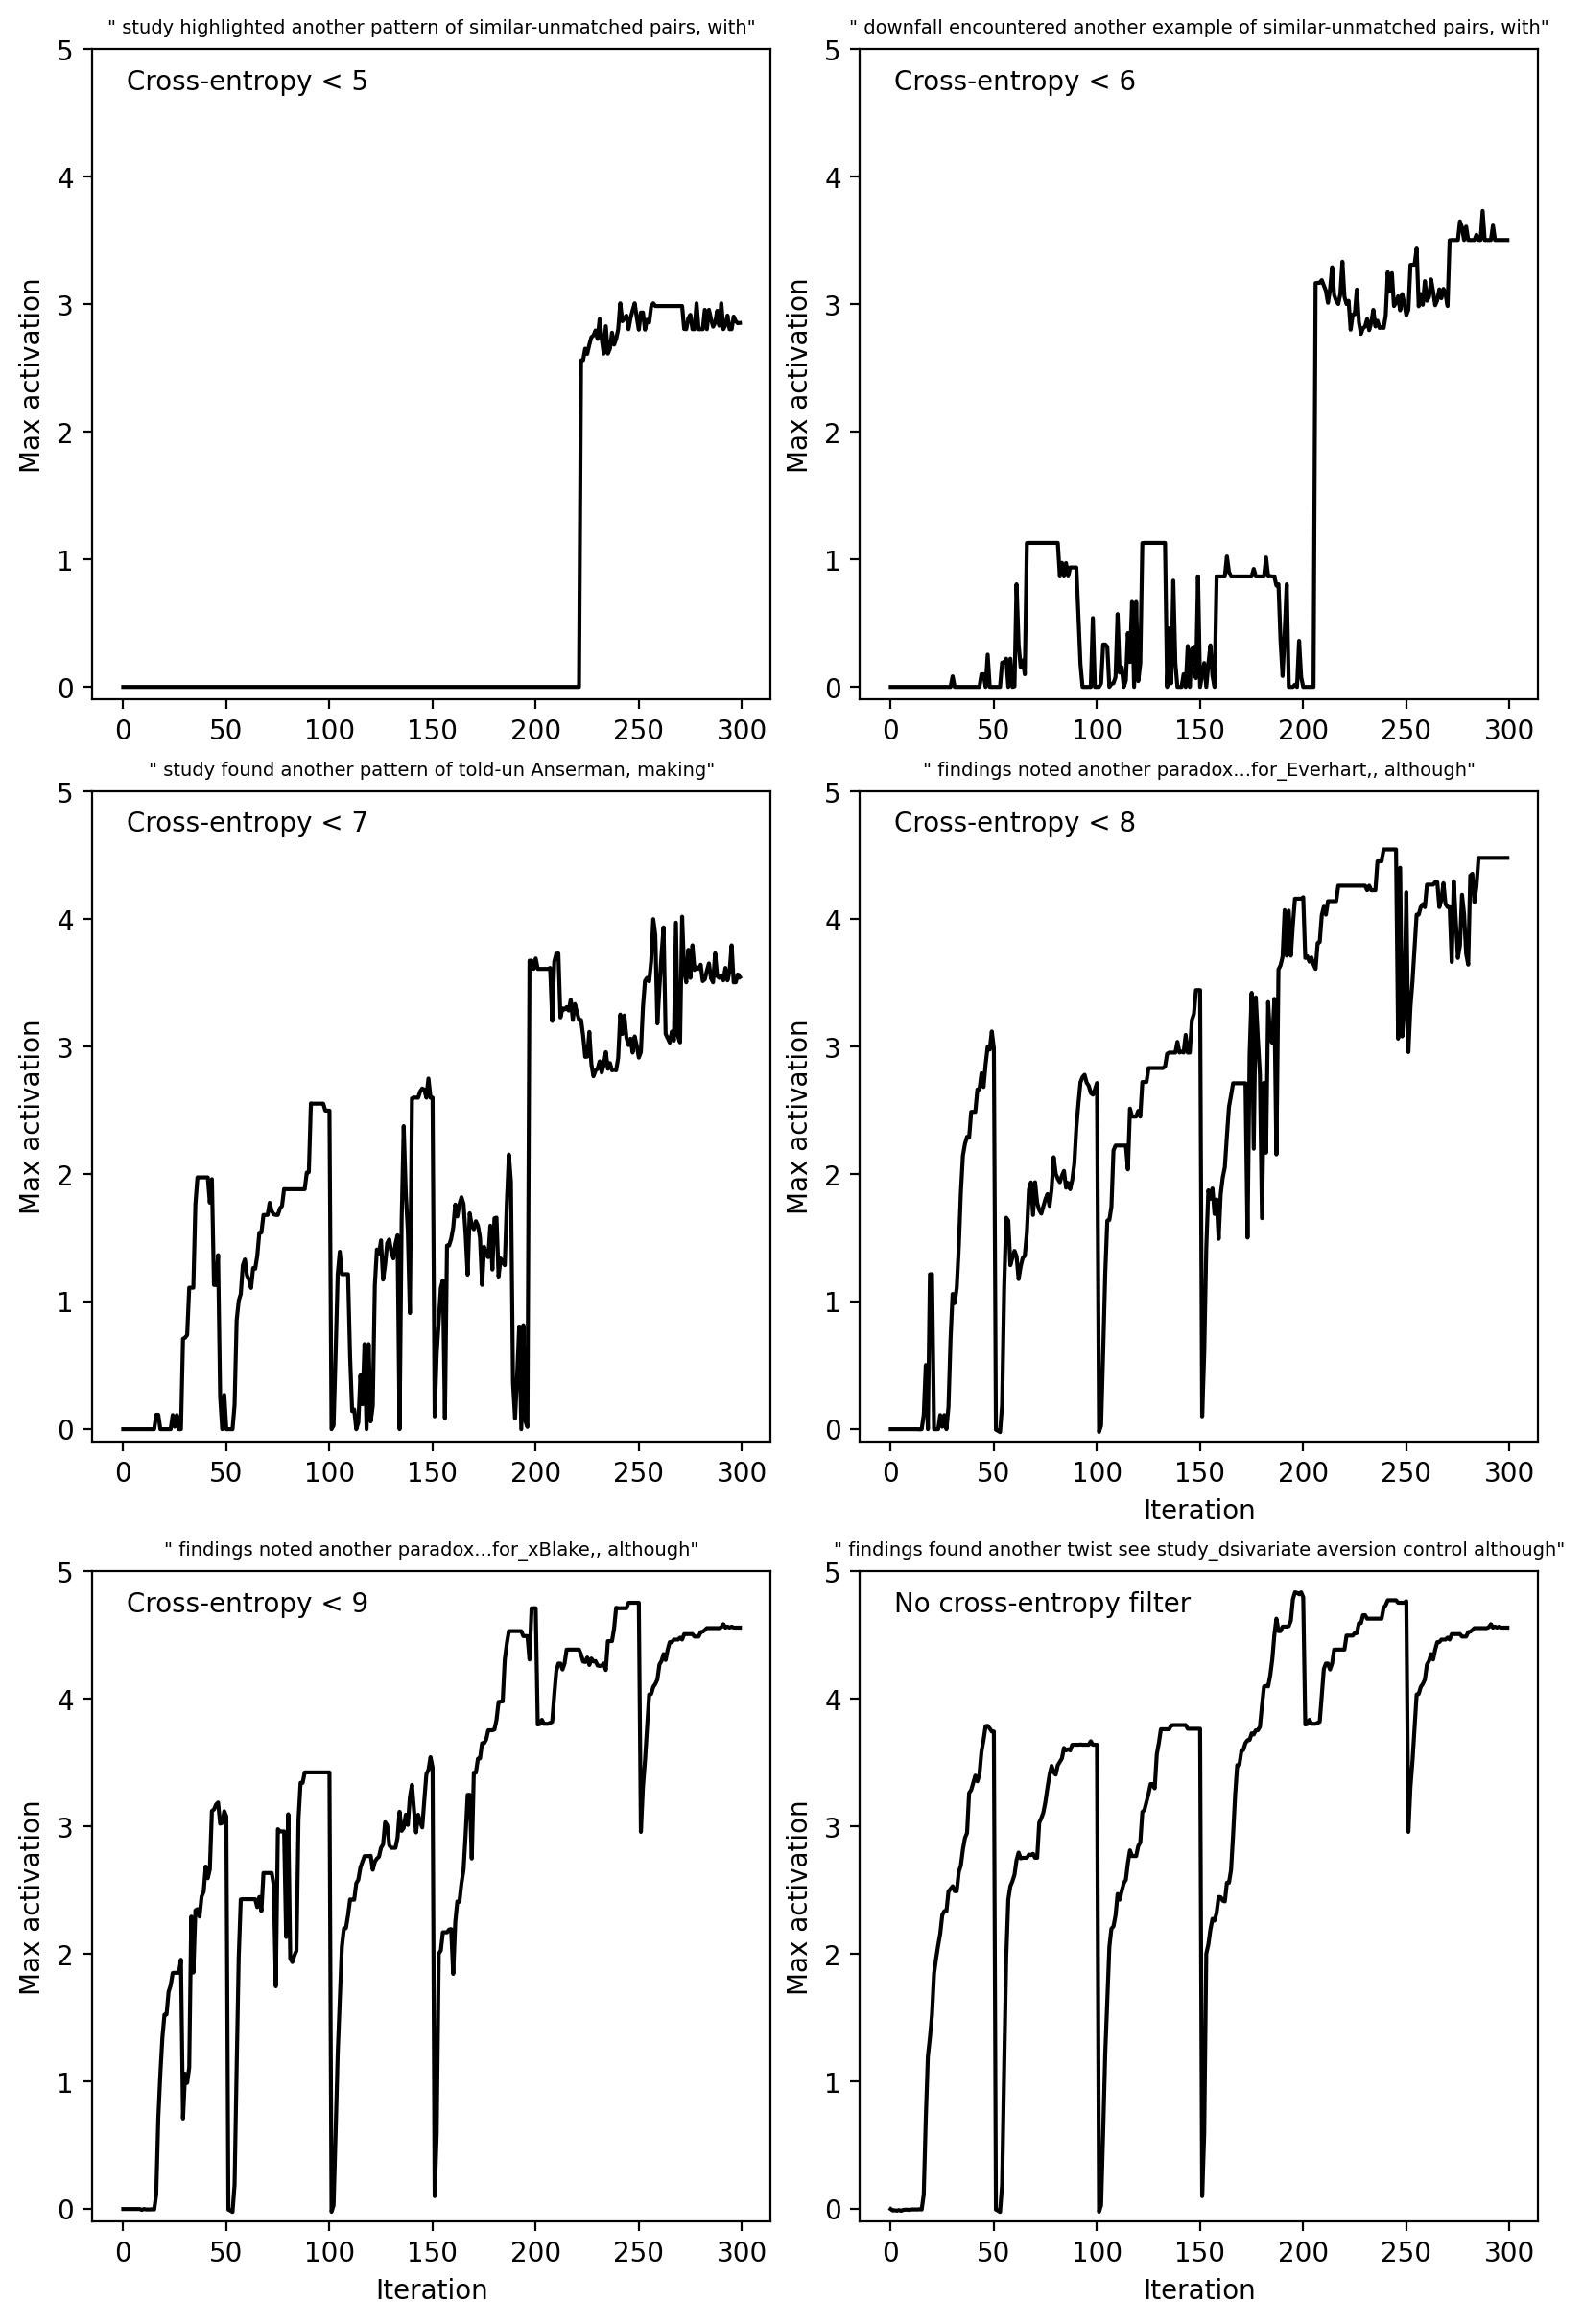

In [8]:
plt.figure(figsize=(8, 12), constrained_layout=True)
for i, thresh in enumerate([5, 6, 7, 8, 9, 15]):
    plt.subplot(3, 2, i + 1)
    best_under = np.where(history.xentropy < thresh, history.target, 0).max(axis=-1)
    plt.plot(best_under, 'k-')
    if i >= 3:
        plt.xlabel("Iteration")
    plt.ylabel("Max activation")
    plt.ylim(-0.1, 5)
    if thresh > 14:
        plt.text(0.05, 0.95, "No cross-entropy filter", transform=plt.gca().transAxes, va="center")
    else:
        plt.text(0.05, 0.95, f"Cross-entropy < {thresh}", transform=plt.gca().transAxes, va="center")

    flat_xe = history.xentropy.flatten()
    flat_target = history.target.flatten()
    best_idx = np.where(flat_xe < thresh, flat_target, 0).argmax()
    best_ids = history.ids.reshape((-1, history.ids.shape[-1]))[best_idx]
    best_text = tokenizer.decode(best_ids)
    plt.title('"' + best_text + '"', fontsize=7)
plt.show()

## Causal token attribution

The visualizations below show the sensitivity to each token in the prompts. We first filter to the 32 "best" alternative tokens based on backpropagated token gradients. Then, amongst those 32 tokens, we calculate two sensitivities:
- the drop in activation from swapping the token to the next most likely token. In the visualization, we show this in the height of the token bars.
- the drop in activation from swapping the token to the least likely token. In the visualization, we show this with the color of the tokens. Darker reds indicate a larger drop in activation. 
  
We show attribution visualizations for each prompt on the Pareto frontier. For all the prompts, swapping the last token can reduce the neuron activation to zero. Swapping other token can reduces the activation much less. The comma in the second-to-last position is also important and often has no viable substitute which is indicated by its tall bar.

In [17]:
for i in range(len(ordering)):
    _, viz_html = resample_viz(
        model,
        tokenizer,
        runner,
        torch.tensor(pareto.ids[ordering[i]]).to(model.device),
        target_name="L8.N1 activation",
    )
    display(HTML(viz_html))

In [18]:
# | output: false
# | echo: false
i = 0
_, viz_html = resample_viz(
    model,
    tokenizer,
    runner,
    torch.tensor(pareto.ids[ordering[i]]).to(model.device),
    target_name="L8.N1 activation",
)
with open("viz.html", "w") as f:
    f.write(viz_html)